# PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle

## Разбираемся с данными

### Импортируем библиотеки

In [487]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from scipy.stats import normaltest

### Загружаем датасеты

In [488]:
hotels = pd.read_csv('hotels.csv')
missed_coords = pd.read_csv('missed_coords.csv')

pd. set_option('display.max_rows', 50)

### Изучаем данные

In [489]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

Видим, что некоторые значения столбцов 'lat' и 'lng' пропущены.

Числовые столбцы: additional_number_of_scoring, average_score, review_total_negative_word_counts, total_number_of_reviews, review_total_positive_word_counts, total_number_of_reviews_reviewer_has_given, reviewer_score, lat, lng.

Строковые столбцы: hotel_address, review_date, hotel_name, reviewer_nationality, negative_review, positive_review, tags, days_since_review.

Столбец, который следует преобразовать в datetime - 'review_date'.

### Составляем план действий

1. Заполнение пропущенных значений
2. Создание новых признаков
3. Кодирование признаков
4. Удаление нечисловых признаков
5. Преобразование признаков
6. Отбор признаков
7. Machine Learning

## Заполнение пропущенных значений

Заполним отсутствующие значения колонок 'lat' и 'lng'.

Для начала, определим, по какому принципу эти пропуски образованы. Предположим, геометка отсутствует у определённых отелей.

Посмотрим:

In [490]:
hotels.hotel_name[hotels.isnull().any(1)].value_counts().head(1)

Fleming s Selection Hotel Wien City    496
Name: hotel_name, dtype: int64

Видим, что у отеля 'Fleming s Selection Hotel Wien City' 496 пропусков.

Проверим, сколько всего записей в датасете об указанном отеле:

In [491]:
len(hotels[hotels.hotel_name == 'Fleming s Selection Hotel Wien City'])

496

Наше предположение подтвердилось.

Найдём полный список отелей без указания координат:

In [492]:
hotels_without_coords = hotels[hotels.isnull().any(1)].hotel_name.unique().tolist()
hotels_without_coords

['Austria Trend Hotel Schloss Wilhelminenberg Wien',
 'Holiday Inn Paris Montmartre',
 'Fleming s Selection Hotel Wien City',
 'Hotel Atlanta',
 'Maison Albar Hotel Paris Op ra Diamond',
 'Derag Livinghotel Kaiser Franz Joseph Vienna',
 'Hotel City Central',
 'NH Collection Barcelona Podium',
 'City Hotel Deutschmeister',
 'Hotel Daniel Vienna',
 'Roomz Vienna',
 'Hotel Pension Baron am Schottentor',
 'Mercure Paris Gare Montparnasse',
 'Hotel Park Villa',
 'Hotel Advance',
 'Renaissance Barcelona Hotel',
 'Cordial Theaterhotel Wien']

И вручную соберём данные во внешнем файле:

In [493]:
missed_coords

,hotel_name,missed_lat,missed_lng
0,Austria Trend Hotel Schloss Wilhelminenberg Wien,48.219560,16.285583
1,Holiday Inn Paris Montmartre,48.888882,2.333157
2,Fleming s Selection Hotel Wien City,48.209369,16.353385
3,Hotel Atlanta,48.220413,16.355811
4,Maison Albar Hotel Paris Op ra Diamond,48.875273,2.323394
5,Derag Livinghotel Kaiser Franz Joseph Vienna,48.246021,16.341540
6,Hotel City Central,48.213588,16.379908
7,NH Collection Barcelona Podium,41.391551,2.177892
8,City Hotel Deutschmeister,48.220886,16.366643
9,Hotel Daniel Vienna,48.188809,16.383790


Добавим эти данные в основную таблицу:

In [494]:
hotels = hotels.merge(missed_coords, how='left', on='hotel_name')

hotels.lat = hotels[['lat','missed_lat']].max(axis=1)
hotels.lng = hotels[['lng','missed_lng']].max(axis=1)

hotels = hotels.drop(['missed_lat', 'missed_lng'], axis=1)


Проверим успешность наших операций:

In [495]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

## Создание новых признаков

### hotel_address

Посмотрим на адреса:

In [496]:
hotels.hotel_address.value_counts().head(25)

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              3587
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     3206
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     3095
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    2688
7 Pepys Street City of London London EC3N 4AF United Kingdom                      2379
1 Inverness Terrace Westminster Borough London W2 3JP United Kingdom              2218
Wrights Lane Kensington and Chelsea London W8 5SP United Kingdom                  2097
225 Edgware Road Westminster Borough London W2 1JU United Kingdom                 1982
1 Waterview Drive Greenwich London SE10 0TW United Kingdom                        1939
4 18 Harrington Gardens Kensington and Chelsea London SW7 4LH United Kingdom      1889
27 Devonshire Terrace Westminster Borough London W2 3DP United Kingdom            1737
Lakeside Way Brent London HA9 0BU United Ki

Обратим внимание на композицию адреса.

Если это Великобритания, то между городом и страной указан индекс. У всех остальных город это предпоследнее слово, а страна - последнее. Кроме того - Великобритания представлена только одним городом - Лондоном.

Добавляем колонки с городом и страной:

In [497]:
hotels['country'] = hotels.hotel_address.apply(lambda x: 'United Kingdom' if x.endswith('United Kingdom') else x.split()[-1])
hotels['city'] = hotels.hotel_address.apply(lambda x: 'London' if x.endswith('United Kingdom') else x.split()[-2])

Посмотрим, из скольких городов и стран наши отели:

In [498]:
hotels.country.value_counts()

United Kingdom    196774
Spain              45132
France             44830
Netherlands        43006
Austria            29178
Italy              27883
Name: country, dtype: int64

In [499]:
hotels.city.value_counts()

London       196774
Barcelona     45132
Paris         44830
Amsterdam     43006
Vienna        29178
Milan         27883
Name: city, dtype: int64

6 городов из соответствующих 6 стран. Дублирующие друг друга колонки. Удалим города и адреса.

In [500]:
hotels = hotels.drop(['city', 'hotel_address'], axis=1)

### additional_number_of_scoring

Можно сложить эту колонку с общим числом отзывов:

In [501]:
hotels['total_plus_additional'] = hotels.additional_number_of_scoring + hotels.total_number_of_reviews

### review_date

В первую очередь, переведём эти данные в datetime:

In [502]:
hotels.review_date = pd.to_datetime(hotels.review_date)

Есть предположение, что нечестные отзывы могут забрасываться пачками в один день. Проверим.

Из дат можно сгенерировать много дополнительных признаков:
1. Количество отзывов у отеля всего
2. Количество отзывов у отеля в конкретный день
3. Дата первого отзыва об отеле
4. Дата последнего отзыва об отеле
5. Количество дней от первого отзыва об отеле до этого
6. Количество дней от этого отзыва об отеле до последнего
7. Количество дней от первого отзыва об отеле до последнего
8. Среднее количество отзывов у отеля в день
9. Медианное количество отзывов у отеля в день
10. Отношение количества отзывов у отеля на конкретый день к среднему
11. Отношение количества отзывов у отеля на конкретый день к медианному

Количество отзывов у отеля в датасете:

In [503]:
reviews_total = hotels.groupby('hotel_name')['review_date'].count().reset_index()
reviews_total = reviews_total.rename(columns={'review_date': 'hotel_review_total'})

hotels = hotels.merge(reviews_total, how='left', on='hotel_name')

Количество отзывов у отеля в конкретный день:

In [504]:
reviews_on_the_date = hotels.groupby(['hotel_name', 'review_date']).size().reset_index()
reviews_on_the_date = reviews_on_the_date.rename(columns={0: 'hotel_reviews_on_the_date'})

hotels = pd.merge(hotels, reviews_on_the_date, on=['hotel_name', 'review_date'])

Дата первого отзыва об отеле:

In [505]:
first_review = hotels.groupby('hotel_name')['review_date'].min().reset_index()
first_review  = first_review.rename(columns={'review_date': 'first_hotel_review_date'})

hotels = hotels.merge(first_review, how='left', on='hotel_name')

Дата последнего отзыва об отеле:

In [506]:
last_review = hotels.groupby('hotel_name')['review_date'].max().reset_index()
last_review  = last_review.rename(columns={'review_date': 'last_hotel_review_date'})

hotels = hotels.merge(last_review, how='left', on='hotel_name')

Количество дней от первого отзыва об отеле до этого:

In [507]:
hotels['days_from_first_to_this_review'] = (hotels.review_date - hotels.first_hotel_review_date).dt.days

Количество дней от этого отзыва об отеле до последнего:

In [508]:
hotels['days_from_this_to_last_review'] = (hotels.last_hotel_review_date - hotels.review_date).dt.days

Количество дней от первого отзыва об отеле до последнего:

In [509]:
hotels['days_from_first_to_last_review'] = (hotels.last_hotel_review_date - hotels.first_hotel_review_date).dt.days

Среднее количество отзывов у отеля в день:

In [510]:
hotels['hotel_average_reviews'] = hotels.hotel_review_total / hotels.days_from_first_to_last_review

Медианное количество отзывов у отеля в день:

In [511]:
median_value = hotels.groupby('hotel_name')['hotel_reviews_on_the_date'].median().reset_index()
median_value = median_value.rename(columns={'hotel_reviews_on_the_date': 'hotel_median_reviews'})

hotels = hotels.merge(median_value, how='left', on='hotel_name')

Отношение количества отзывов у отеля на конкретый день к среднему:

In [512]:
hotels['reviews_to_average'] = hotels['hotel_reviews_on_the_date'] / hotels['hotel_average_reviews']

Отношение количества отзывов у отеля на конкретый день к медианному:

In [513]:
hotels['reviews_to_median'] = hotels['hotel_reviews_on_the_date'] / hotels['hotel_median_reviews']

### reviewer_nationality

Посмотрим, из каких стран наши пользователи:

In [514]:
hotels.reviewer_nationality.value_counts()

 United Kingdom               184033
 United States of America      26541
 Australia                     16239
 Ireland                       11126
 United Arab Emirates           7617
                               ...  
 Cook Islands                      1
 Guinea                            1
 Comoros                           1
 Anguilla                          1
 Saint Barts                       1
Name: reviewer_nationality, Length: 225, dtype: int64

Присмотримся к значению:

In [515]:
hotels.reviewer_nationality[0]

' United Kingdom '

Надо убрать пробелы в начале и конце строки:

In [516]:
hotels.reviewer_nationality = hotels.reviewer_nationality.apply(lambda x: x[1:-1])

Проверим:

In [517]:
hotels.reviewer_nationality[0]

'United Kingdom'

Предположим, что совпадение страны пользователя и страны отеля может повлиять на оценку.

Добавим новый признак:

In [518]:
hotels['hotel_and_reviewer_same_country'] = hotels.apply(lambda x: 1 if x.country == x.reviewer_nationality else 0, axis=1)

### negative_review

Посмотрим на самые частые негативные отзывы:

In [519]:
hotels.negative_review.value_counts().head(15)

No Negative        95907
 Nothing           10737
 Nothing            3154
 nothing            1660
 N A                 802
 None                737
                     606
 N a                 384
 Breakfast           296
 Small room          283
 Location            281
 All good            251
 Everything          251
 Nothing really      240
 none                223
Name: negative_review, dtype: int64

Обратим внимание на то, что если првести весь текст к нижнему регистру и убрать лишние пробелы, то количество уникальных значений чильно снизится.

Почистим данные:

In [520]:
hotels.negative_review = hotels.negative_review.apply(lambda x: ' '.join(x.split()))
hotels.negative_review = hotels.negative_review.apply(lambda x: x.lower())

Создадим список из самых частовстречающихся текстов из негативных отзывов (которые на самом деле несут позитивный смысл):

In [521]:
top_negative_review_texts = hotels.negative_review.value_counts().head(6).index.to_list()

Создадим колонку, которая будет указывать на то, что указанный негативный отзыв из частых:

In [522]:
hotels['is_top_negative_text'] = hotels.negative_review.apply(lambda x: 1 if x in top_negative_review_texts else 0)

### total_number_of_reviews

Можем вычислить количество невошедших в датасет отзывов об отеле:

In [523]:
hotels['reviews_not_in_dataset'] = hotels.total_number_of_reviews - hotels.hotel_review_total

### positive_review

Проведём такую же обработку данных, как и со столбцом 'negative_review':

In [524]:
hotels.positive_review = hotels.positive_review.apply(lambda x: ' '.join(x.split()))
hotels.positive_review = hotels.positive_review.apply(lambda x: x.lower())

И посмотрим на самые частые положительные отзывы:

In [525]:
hotels.positive_review.value_counts().head(5)

no positive       26885
location           8843
everything         2453
nothing            1297
great location     1291
Name: positive_review, dtype: int64

Значения 'no positive' и 'nothing' несут абсолютно негативное значение, а значение 'everything' - наоборот.

Добавим 2 новых признака:

In [526]:
nothing_positive = ['no positive', 'nothing']

hotels['nothing_in_positive_review'] = hotels.positive_review.apply(lambda x: 1 if x in nothing_positive else 0)
hotels['everything_in_positive_review'] = hotels.positive_review.apply(lambda x: 1 if x == 'everything' else 0)

### review_total_negative_word_counts и review_total_positive_word_counts

Из этих двух столбцов можно соорудить новый, в котором будет разница между количеством слов в позитивном и негативном отзывах:

In [527]:
hotels['word_balance'] = hotels.review_total_positive_word_counts - hotels.review_total_negative_word_counts

### tags

Взглянем на данные, с которыми предстоит работать:

In [528]:
hotels.tags[0]

"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']"

Данные кажутся списком, но на самом деле это строка:

In [529]:
type(hotels.tags[0])

str

Уберём лишние символы и конвертируем строки в списки:

In [530]:
hotels.tags = hotels.tags.apply(lambda x: str(x).replace('[', ''))
hotels.tags = hotels.tags.apply(lambda x: str(x).replace(']', ''))
hotels.tags = hotels.tags.apply(lambda x: str(x).replace("' ", ""))
hotels.tags = hotels.tags.apply(lambda x: str(x).replace(" '", ""))
hotels.tags = hotels.tags.apply(lambda x: str(x).replace(', ', ','))
hotels.tags = hotels.tags.apply(lambda x: str(x).split(','))

Теперь посмотрим на самые частоиспользуемые теги:

In [531]:
hotels.tags.explode().value_counts().head(10)

Leisure trip                      313593
Submitted from a mobile device    230778
Couple                            189212
Stayed 1 night                    145373
Stayed 2 nights                   100263
Solo traveler                      81235
Stayed 3 nights                    72000
Business trip                      61989
Group                              49088
Family with young children         45836
Name: tags, dtype: int64

Предположим, что нечестные отзывы будут чаще всего с тегами 'Stayed 1 night' и 'Solo traveler'.

Создадим дополнительный признак, который будет сообщать о том, что использован хотя бы один из указанных тегов:

In [532]:
hotels['one_night_or_solo'] = hotels.tags.apply(lambda x: 1 if ('Stayed 1 night' or 'Solo traveler') in x else 0)

Предположим, что количество указанных тегов влияет на оценку.

Создадим колонку, в которой будет записано количество тегов, использованных в отзыве:

In [533]:
hotels['tags_quantity'] = hotels['tags'].apply(lambda x: len(x))

Также предположим, что резко отличающееся количество указанных тегов от медианного может повлиять на оценку.

Добавим ещё 2 колонки.

Первую - медианное количество тегов, использованных в отзывах к этому отелю:

In [534]:
median_tags = hotels.groupby('hotel_name')['tags_quantity'].median().reset_index()
median_tags = median_tags.rename(columns={'tags_quantity': 'hotel_median_tags'})

hotels = hotels.merge(median_tags, on=['hotel_name'])

Вторую - отношение количества использованных в обзоре тегов к медиане:

In [535]:
hotels['tags_to_median'] = hotels['tags_quantity'] / hotels['hotel_median_tags']

### days_since_review

Посмотрим на данные:

In [536]:
hotels.days_since_review[0]

'531 day'

Это строка. Удалим ' day' и изменим тип на число:

In [537]:
hotels.days_since_review = hotels.days_since_review.apply(lambda x: int(x[:-4]))

## Кодирование признаков

Снова ознакомимся с данными:

In [538]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386803 entries, 0 to 386802
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                386803 non-null  int64         
 1   review_date                                 386803 non-null  datetime64[ns]
 2   average_score                               386803 non-null  float64       
 3   hotel_name                                  386803 non-null  object        
 4   reviewer_nationality                        386803 non-null  object        
 5   negative_review                             386803 non-null  object        
 6   review_total_negative_word_counts           386803 non-null  int64         
 7   total_number_of_reviews                     386803 non-null  int64         
 8   positive_review                             386803 non-null  object       

### hotel_name

Будем использовать LabelEncoder:

In [539]:
le = LabelEncoder()
le.fit(hotels.hotel_name)
hotels['hotel_name'] = le.transform(hotels.hotel_name)

### reviewer_nationality

Будем использовать LabelEncoder:

In [540]:
le.fit(hotels.reviewer_nationality)
hotels['reviewer_nationality'] = le.transform(hotels.reviewer_nationality)

### country

Закодируем страны через OneHotEncoder:

In [541]:
encoder = ce.OneHotEncoder(cols=['country'])
type_bin = encoder.fit_transform(hotels['country'])
hotels = pd.concat([hotels, type_bin], axis=1)

## Удаление нечисловых признаков

Снова ознакомимся с данными:

In [542]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386803 entries, 0 to 386802
Data columns (total 45 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                386803 non-null  int64         
 1   review_date                                 386803 non-null  datetime64[ns]
 2   average_score                               386803 non-null  float64       
 3   hotel_name                                  386803 non-null  int64         
 4   reviewer_nationality                        386803 non-null  int64         
 5   negative_review                             386803 non-null  object        
 6   review_total_negative_word_counts           386803 non-null  int64         
 7   total_number_of_reviews                     386803 non-null  int64         
 8   positive_review                             386803 non-null  object       

Удалим лишнее:

In [543]:
hotels = hotels.drop(['review_date', 'negative_review', 'positive_review', 'tags', 'country',
                      'first_hotel_review_date', 'last_hotel_review_date'], axis=1)

## Отбор признаков

Разбиваем датафрейм на части, Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей):

In [544]:
X = hotels.drop(['reviewer_score'], axis = 1)
y = hotels['reviewer_score']
y = y.astype('int')

Признаки могут дублировать информацию. Анализ мультиколлинеарности мы будем использовать, чтобы выбрать уникальные признаки для модели:

<AxesSubplot:>

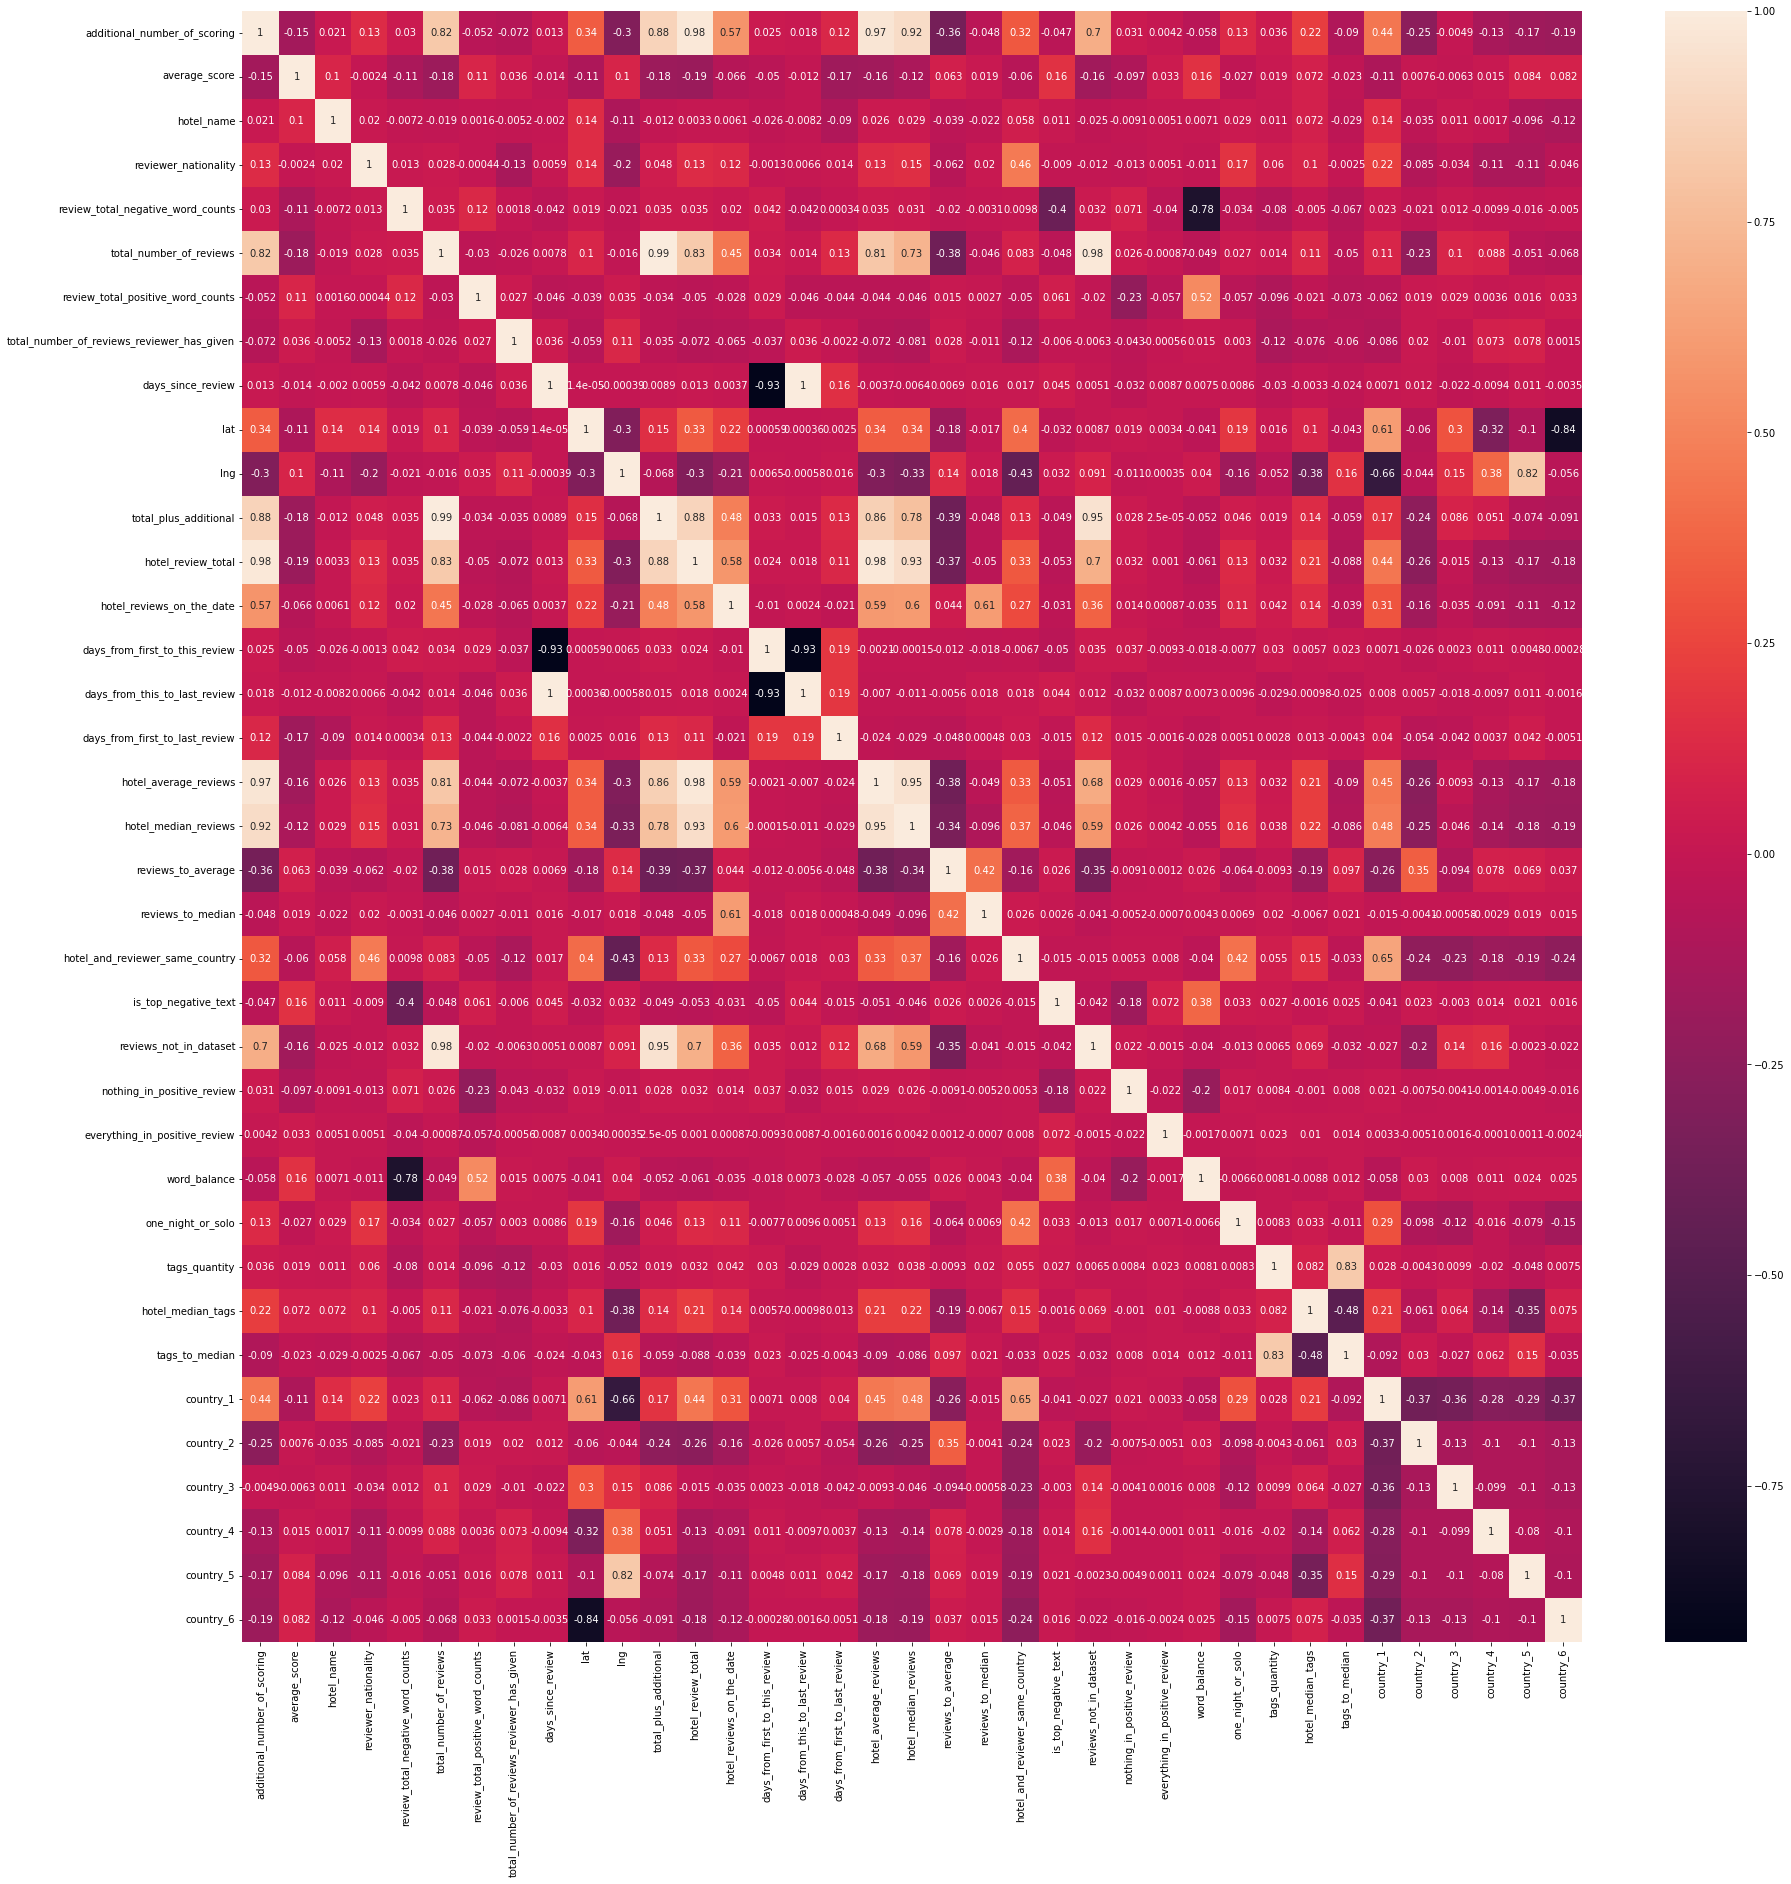

In [545]:
plt.figure(figsize=(30, 30))
sns.heatmap(X.corr(), annot=True)

Удалим дублирующие друг друга признаки:

In [546]:
X = X.drop(['total_number_of_reviews', 'total_plus_additional', 'hotel_review_total', 'hotel_average_reviews',
            'additional_number_of_scoring', 'word_balance', 'days_from_first_to_this_review', 'days_from_this_to_last_review',
            'lat', 'lng', 'tags_to_median'], axis=1)

И снова посмотрим на тепловую карту корреляции:

<AxesSubplot:>

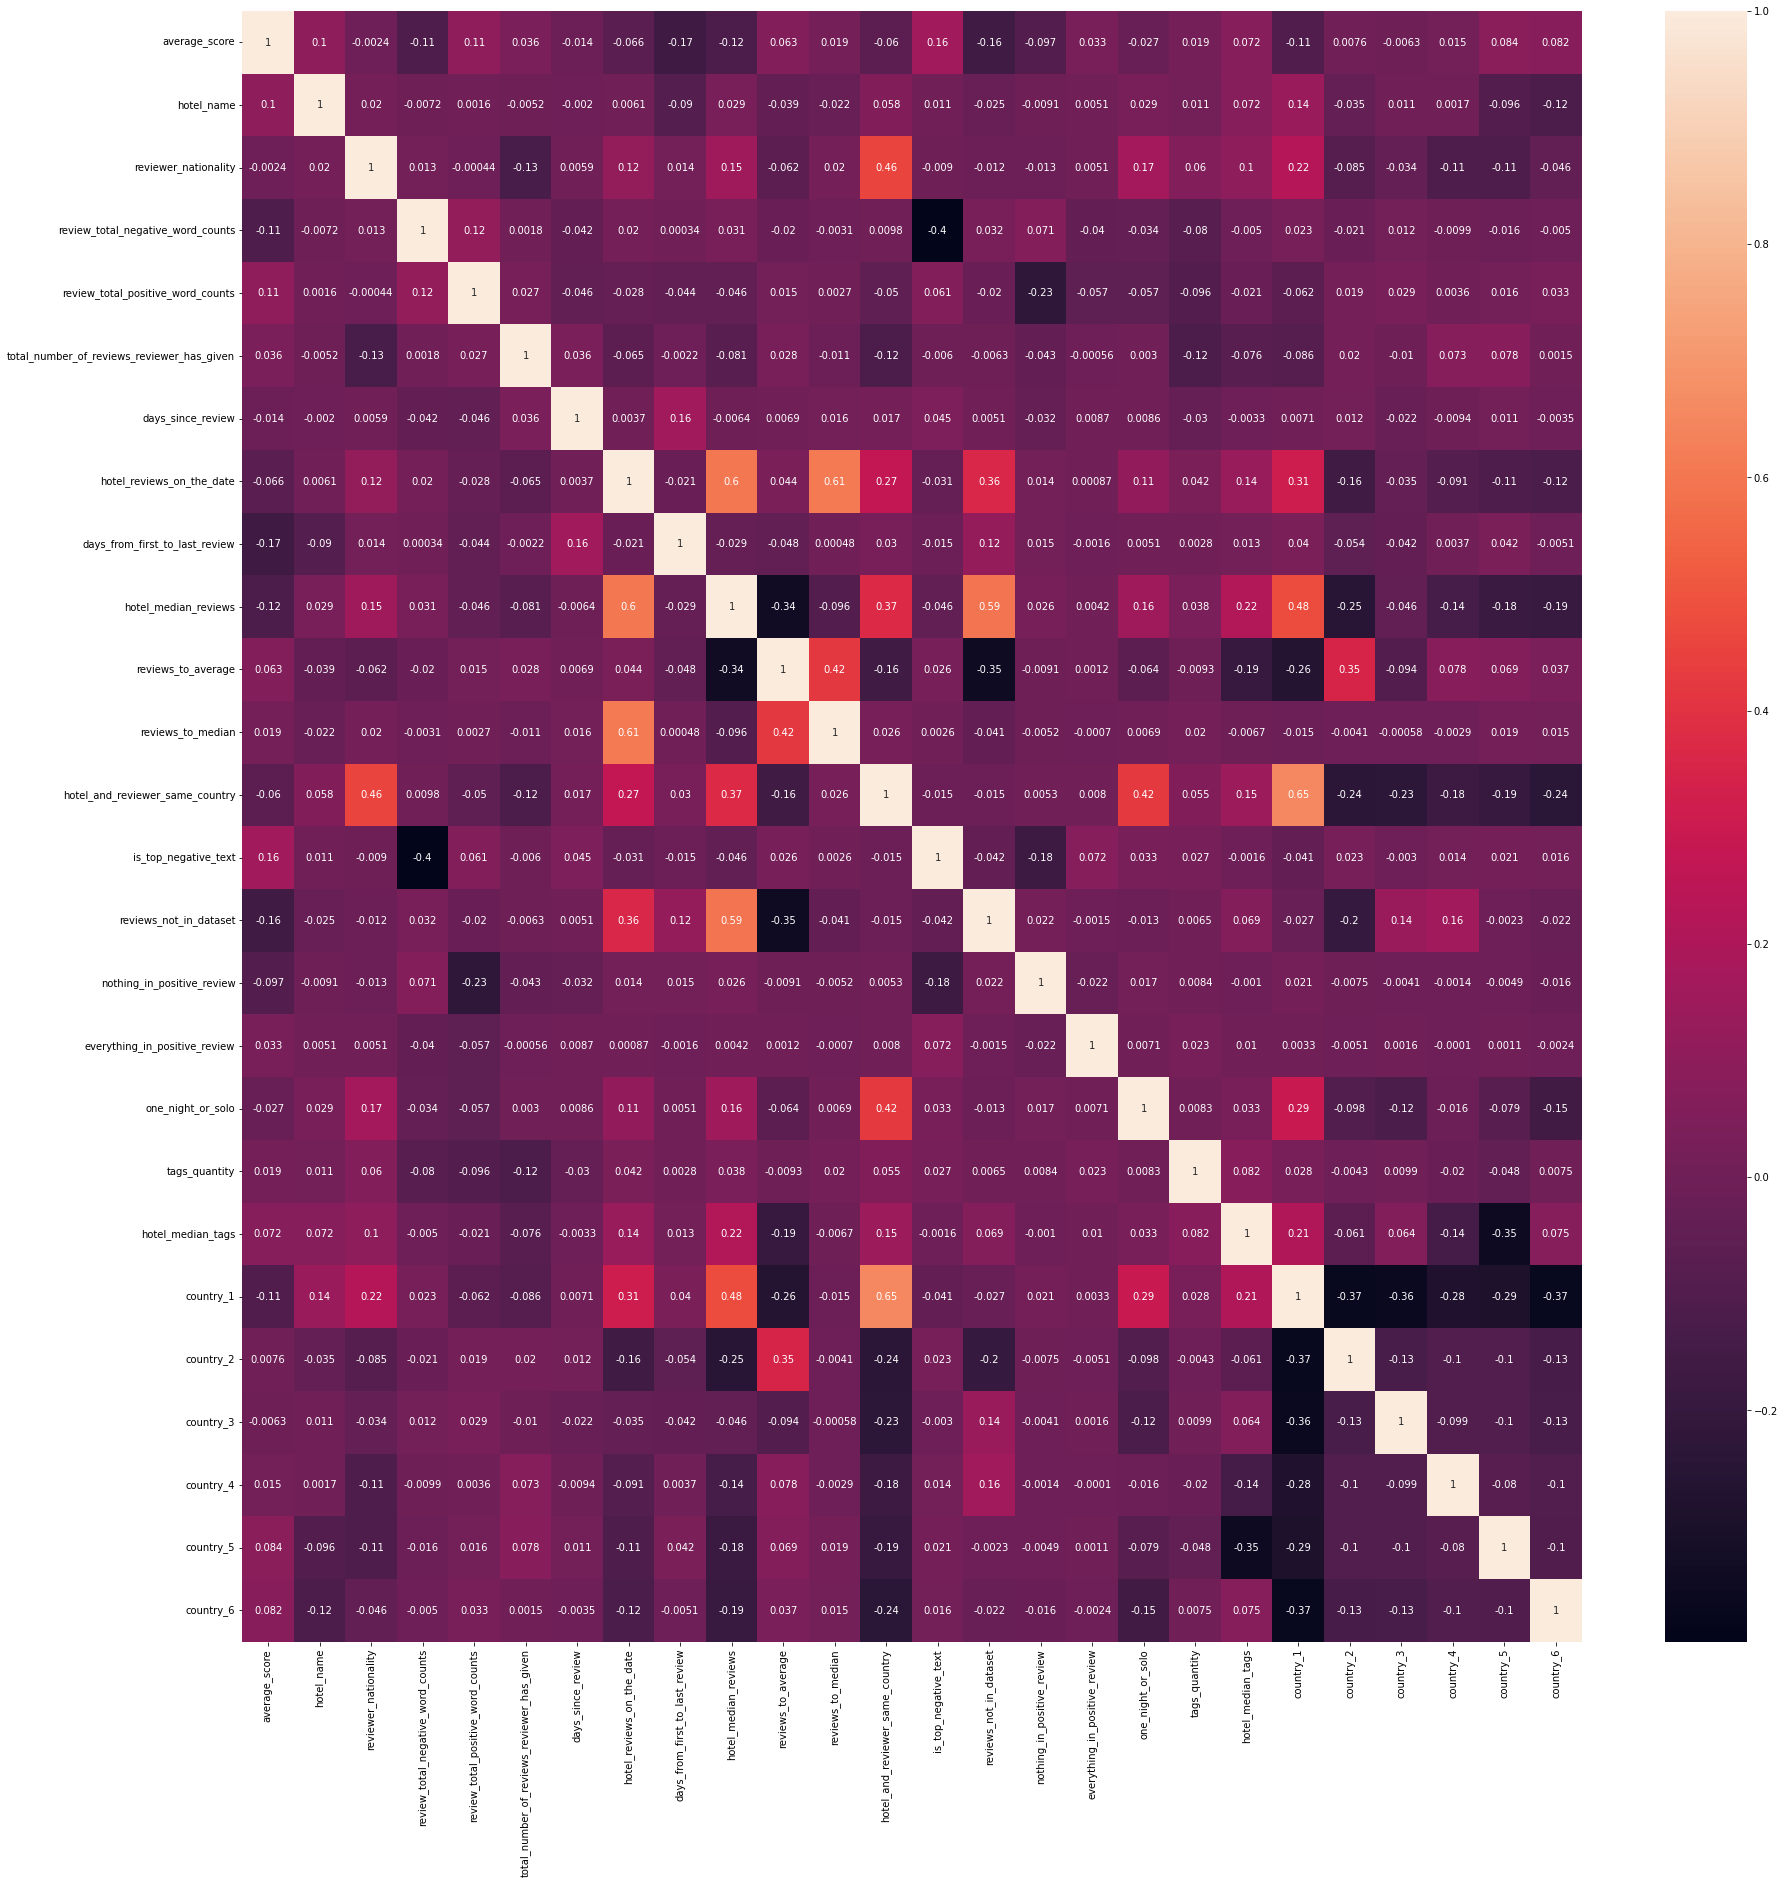

In [547]:
plt.figure(figsize=(30, 30))
sns.heatmap(X.corr(), annot=True)

Разделим признаки по типу, перечислим их:

In [549]:
# непрерывные признаки
num_cols = ['average_score', 'review_total_negative_word_counts', 'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'hotel_reviews_on_the_date',
            'days_from_first_to_last_review', 'hotel_median_reviews', 'reviews_to_average', 'reviews_to_median',
            'reviews_not_in_dataset', 'tags_quantity', 'hotel_median_tags']

# категориальные признаки
cat_cols = ['hotel_name', 'reviewer_nationality', 'hotel_and_reviewer_same_country', 'is_top_negative_text',
            'nothing_in_positive_review', 'everything_in_positive_review', 'one_night_or_solo', 'country_1', 'country_2',
            'country_3', 'country_4', 'country_5', 'country_6']

Для оценки значимости категориальных переменных будем использовать изученный нами непараметрический тест хи-квадрат, реализованный в библиотеке sklearn.feature_selection.chi2. Метод возвращает массив значений хи-квадрат и p-value для каждого признака. Используем только значения хи-квадрат и выведем их на графике:

<AxesSubplot:>

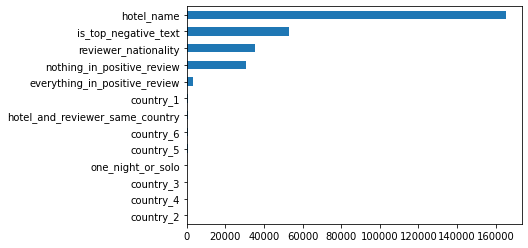

In [550]:
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Возьмём в обучение первые 4 признака.

Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn. В основе метода оценки значимости переменных лежит изученный вами в юнитах по статистике анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

<AxesSubplot:>

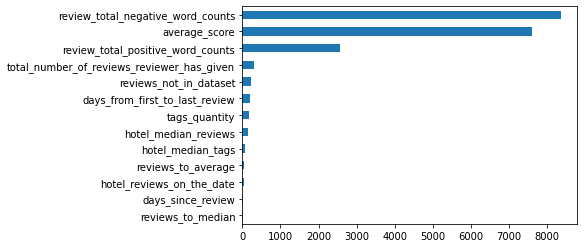

In [551]:
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Возьмём в обучение первые 3 признака.

Составляем датасет для обучения модели:

In [552]:
X = X[['hotel_name', 'is_top_negative_text', 'reviewer_nationality', 'nothing_in_positive_review',
       'review_total_negative_word_counts', 'average_score', 'review_total_positive_word_counts']]

## Machine Learning

Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.

Для тестирования мы будем использовать 25% от исходного датасета:

In [553]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Создаём модель:

In [554]:
regr = RandomForestRegressor(n_estimators=100)

Обучаем модель на тестовом наборе данных:

In [555]:
regr.fit(X_train, y_train)

RandomForestRegressor()

Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
Предсказанные значения записываем в переменную y_pred:

In [556]:
y_pred = regr.predict(X_test)

Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются.
Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических:

In [557]:
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.16301350184065358
